# Stress Testing

In [1]:
import urllib.request
import matplotlib.pyplot as plt
import aiohttp
import asyncio
import json
import random
from io import BytesIO
from PIL import Image, ImageOps
%matplotlib inline

In [2]:
print(aiohttp.__version__)  # 2.0.3

2.0.3


In [3]:
# SET
NUM = 100
CONC = 50
SERVER_URL = 'http://wincntkdemo.azurewebsites.net/api/uploader'

In [4]:
def get_one_image(url):
    urllib.request.urlretrieve(url, "test.jpg")
    plt.axis('off')
    plt.imshow(Image.open('test.jpg'))   

In [5]:
def gen_variations_of_one_image(num):
    out_images = []
    imagefile = open('test.jpg', 'rb')
    img = Image.open(BytesIO(imagefile.read())).convert('RGB')
    img = ImageOps.fit(img, (224, 224), Image.ANTIALIAS)
    # Flip the colours for one-pixel
    # "Different Image"
    for i in range(num):
        diff_img = img.copy()
        rndm_pixel_x_y = (random.randint(0, diff_img.size[0]-1), 
                          random.randint(0, diff_img.size[1]-1))
        current_color = diff_img.getpixel(rndm_pixel_x_y)
        diff_img.putpixel(rndm_pixel_x_y, current_color[::-1])
        # Turn image into IO
        ret_imgio = BytesIO()
        diff_img.save(ret_imgio, 'PNG')
        out_images.append(ret_imgio.getvalue())
    return out_images

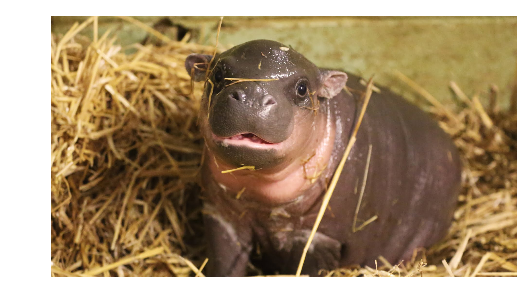

In [6]:
get_one_image("https://i.ytimg.com/vi/96xC5JIkIpQ/maxresdefault.jpg")

In [7]:
images = gen_variations_of_one_image(NUM)

In [8]:
url_list = [[SERVER_URL, {'imagefile':pic}] for pic in images]

In [9]:
def handle_req(data):
    return json.loads(data.decode('utf-8'))
 
def chunked_http_client(num_chunks, s):
    # Use semaphore to limit number of requests
    semaphore = asyncio.Semaphore(num_chunks)
    @asyncio.coroutine
    def http_get(dta):
        nonlocal semaphore
        with (yield from semaphore):
            url, img = dta
            response = yield from s.request('post', url, data=img)
            body = yield from response.content.read()
            yield from response.wait_for_close()
        return body
    return http_get
 
def run_experiment(urls, _session):
    http_client = chunked_http_client(num_chunks=CONC, s=_session)
    # http_client returns futures, save all the futures to a list
    tasks = [http_client(url) for url in urls]
    rsponses = []
    # wait for futures to be ready then iterate over them
    for future in asyncio.as_completed(tasks):
        data = yield from future
        try:
            out = handle_req(data)
            rsponses.append(out)
        except Exception as err:
            print("Error {0}".format(err))
    return rsponses

In [10]:
%%time
# Expect to see some 'errors' meaning requests are expiring on 'queue'
# i.e. we can't increase concurrency any more
with aiohttp.ClientSession() as session:  # We create a persistent connection
    loop = asyncio.get_event_loop()
    complete_responses = loop.run_until_complete(run_experiment(url_list, session)) 

Creating a client session outside of coroutine
client_session: <aiohttp.client.ClientSession object at 0x7fde77970cf8>


CPU times: user 265 ms, sys: 33.2 ms, total: 299 ms
Wall time: 1min 26s


In [11]:
len(complete_responses)
print(complete_responses[:5])

['hippopotamus', 'hippopotamus', 'hippopotamus', 'hippopotamus', 'hippopotamus']


In [12]:
# Total responses
len(complete_responses)

100

In [13]:
# Successful responses
complete_responses.count(complete_responses[1])

100

In [14]:
# In this example
print(86/NUM, " seconds per image")

0.86  seconds per image
